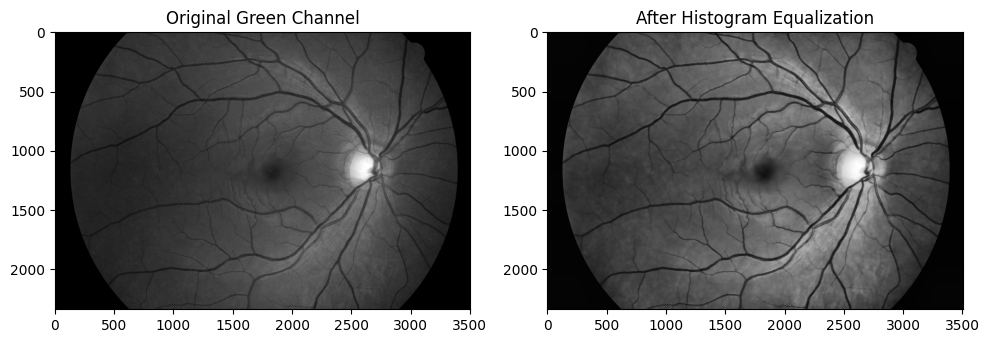

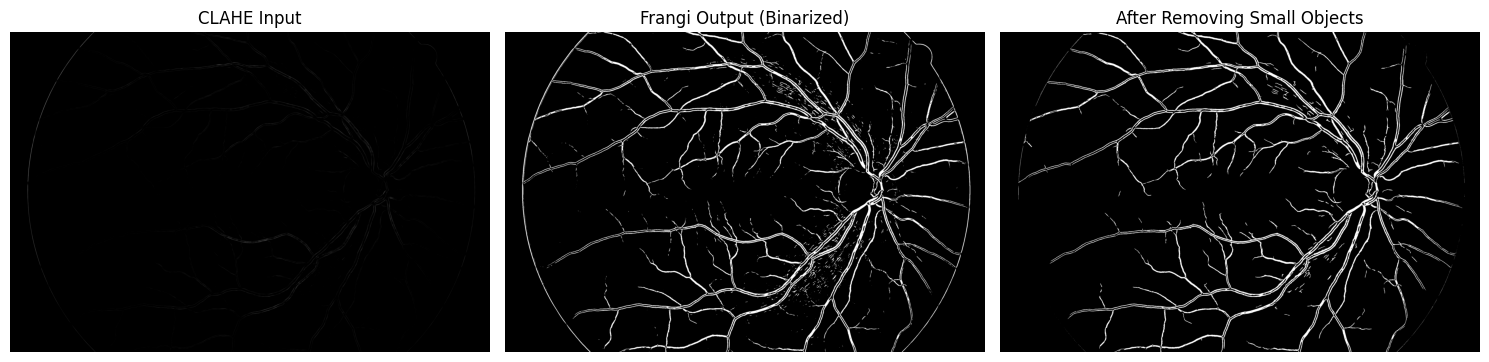

Maksymalna wartość w predykcji: 255
Maksymalna wartość w masce eksperckiej: 255


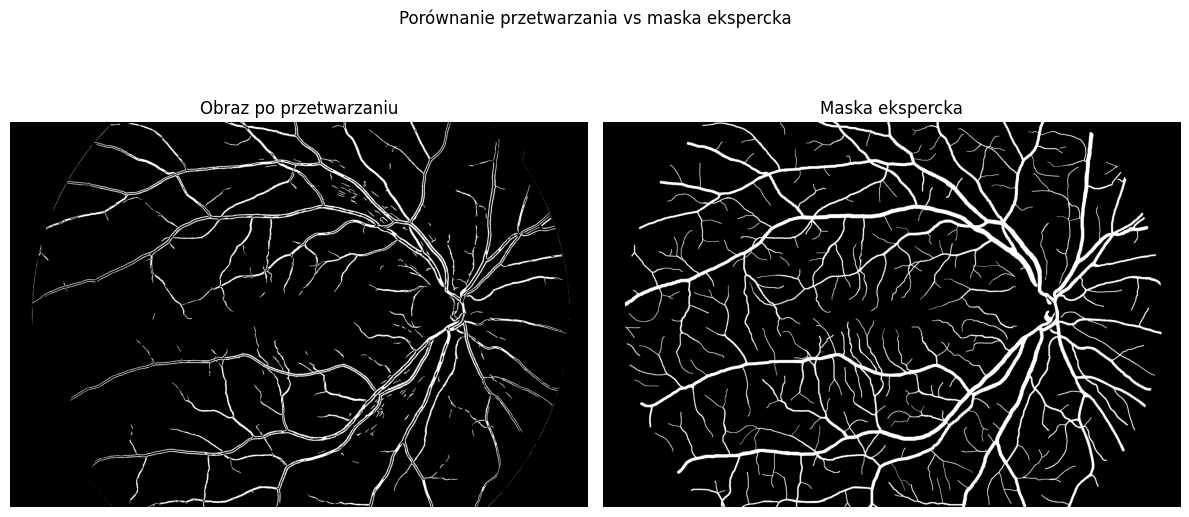

| Method     |   Accuracy |   Sensitivity |   Specificity |   Balanced Accuracy |   G-Mean |
|:-----------|-----------:|--------------:|--------------:|--------------------:|---------:|
| Normalized |     0.9425 |        0.4929 |        0.9935 |              0.7432 |   0.6998 |


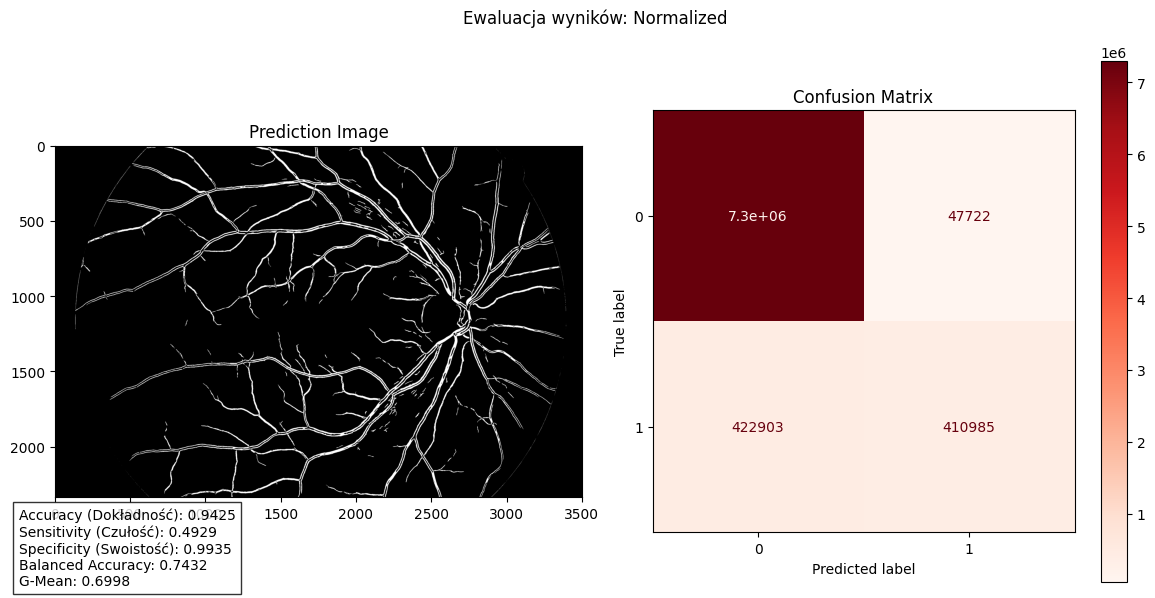

In [1]:
import cv2
import numpy as np
import math
from matplotlib import pyplot as plt
from skimage.filters import frangi
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, ConfusionMatrixDisplay
from tabulate import tabulate
from skimage.morphology import remove_small_objects
from skimage.measure import label

def evaluate_segmentation(img_pred, img_true):

    # Sprawdzenie maksymalnych wartości
    print("Maksymalna wartość w predykcji:", img_pred.max())
    print("Maksymalna wartość w masce eksperckiej:", img_true.max())

    # Wizualizacja: Segmentacja vs Maska ekspercka
    fig_result = plt.figure(figsize=(12, 6))
    fig_result.suptitle('Porównanie przetwarzania vs maska ekspercka')

    # Segmentacja
    ax1 = fig_result.add_subplot(1, 2, 1)
    ax1.imshow(img_pred, cmap='gray')
    ax1.set_title("Obraz po przetwarzaniu")
    ax1.axis('off')

    # Maska ekspercka
    ax2 = fig_result.add_subplot(1, 2, 2)
    ax2.imshow(img_true, cmap='gray')
    ax2.set_title("Maska ekspercka")
    ax2.axis('off')

    fig_result.tight_layout()
    plt.show()

    # Normalizacja do zakresu [0, 1]
    y_true = img_true.ravel() / img_true.max()
    y_pred = img_pred.ravel() / img_pred.max()

    # Binaryzacja: naczynia = 1, tło = 0
    y_true_binary = (y_true > 0.5).astype(np.uint8)
    y_pred_binary = (y_pred > 0.5).astype(np.uint8)

    # Obliczenie metryk i macierzy pomyłek
    cm = confusion_matrix(y_true_binary, y_pred_binary)
    tn, fp, fn, tp = cm.ravel()

    # Accuracy (dokładność): ogólny odsetek poprawnych klasyfikacji
    accuracy = accuracy_score(y_true_binary, y_pred_binary)

    # Sensitivity (czułość / recall): jak dobrze wykrywane są naczynia (True Positive Rate)
    sensitivity = recall_score(y_true_binary, y_pred_binary)

    # Specificity (swoistość): jak dobrze wykrywane jest tło (True Negative Rate)
    specificity = tn / (tn + fp)

    # Balanced Accuracy: średnia czułości i swoistości (bardziej odporna na niezbalansowane dane)
    balanced_accuracy = (sensitivity + specificity) / 2

    # G-Mean: geometryczna średnia czułości i swoistości (karze nierównowagę)
    g_mean = math.sqrt(sensitivity * specificity)

    # Wyświetlenie metryk w tabeli
    headers = ["Method", "Accuracy", "Sensitivity", "Specificity", "Balanced Accuracy", "G-Mean"]
    data = [["Normalized", f"{accuracy:.4f}", f"{sensitivity:.4f}", f"{specificity:.4f}",
            f"{balanced_accuracy:.4f}", f"{g_mean:.4f}"]]
    print(tabulate(data, headers=headers, tablefmt="pipe"))

    # Wizualizacja wyników
    fig_result = plt.figure(figsize=(12, 6))
    fig_result.suptitle('Ewaluacja wyników: Normalized')

    # Obraz wynikowy
    ax_img = fig_result.add_subplot(1, 2, 1)
    ax_img.imshow(img_pred, cmap='gray')
    ax_img.set_title("Prediction Image")

    # Macierz pomyłek
    ax_cm = fig_result.add_subplot(1, 2, 2)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=ax_cm, cmap='Reds', colorbar=True)
    ax_cm.set_title("Confusion Matrix")

    # Tekst z metrykami (opisowymi)
    metrics_text = (
        f"Accuracy (Dokładność): {accuracy:.4f}\n"
        f"Sensitivity (Czułość): {sensitivity:.4f}\n"
        f"Specificity (Swoistość): {specificity:.4f}\n"
        f"Balanced Accuracy: {balanced_accuracy:.4f}\n"
        f"G-Mean: {g_mean:.4f}"
    )
    fig_result.text(0.02, 0.02, metrics_text, fontsize=10,
                    bbox=dict(facecolor='white', alpha=0.8))

    plt.tight_layout()
    plt.show()

def remove_image_border(color_img: np.ndarray, image: np.ndarray) -> np.ndarray:
    hsv = cv2.cvtColor(color_img, cv2.COLOR_BGR2HSV)
    lower = np.array([0, 0, 80])
    upper = np.array([255, 255, 255])
    mask = cv2.inRange(hsv, lower, upper)
    return cv2.bitwise_and(image, mask)

# === Wczytanie obrazu i wyciagniecie tylko kanału zielonego ===
img_rgb = cv2.imread("dane/obrazy/01_h.jpg")
img_rgb = cv2.cvtColor(img_rgb, cv2.COLOR_BGR2RGB)
green_channel = img_rgb[:, :, 1]

# === Wyrównanie histogramu i odszumienie (słabe wyniki we Frangim bez tego kroku) ===
green_channel = np.clip(green_channel, 10, 245)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
normalized_image = clahe.apply(green_channel)
removed_noises = cv2.fastNlMeansDenoising(normalized_image, None, 15)

# Visualize CLAHE
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Green Channel")
plt.imshow(green_channel, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("After Histogram Equalization")
plt.imshow(removed_noises, cmap='gray')
plt.tight_layout()

# === Filtr Frangi i agresywny threshold (Próbowano z Otsu - pogarszało wyniki)===
vessels = frangi(removed_noises, black_ridges=True)
vessels = vessels * (255.0 / vessels.max())
vessels = vessels.astype(np.uint8)
_, thresh = cv2.threshold(vessels, 0, 255, cv2.THRESH_BINARY)

# === Usuwanie pozostałości za pomocą remove_small_objects (były próby operacjami morfologicznymi ale za bardzo znikały naczynia) ===
binary = thresh > 0
cleaned = remove_small_objects(label(binary), min_size=100)
cleaned = cleaned.astype(np.uint8) * 255
cleaned = np.where(cleaned > 0, 1, 0)

# == Usunięcie krawędzi ==
img_cleaned_uint8 = (cleaned * 255).astype(np.uint8)
cleaned = remove_image_border(img_rgb, img_cleaned_uint8)


# === Visualize Results ===
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title("CLAHE Input")
plt.imshow(vessels, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Frangi Output (Binarized)")
plt.imshow(thresh, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("After Removing Small Objects")
plt.imshow(cleaned, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()

img_true = cv2.imread('dane/naczynia/01_h.tif', cv2.IMREAD_GRAYSCALE)

evaluate_segmentation(cleaned, img_true)

